# Wisesight Sentiment Analysis

This notebook details the steps taken to create a sentiment analyzer using data from [Wisesight Sentiment Corpus](https://github.com/PyThaiNLP/wisesight-sentiment/). Evaluation metric is overall accuracy across `neg`ative, `pos`itive, `neu`tral and `q`uestion classes. We give examples using logistic regression and [ULMFit](https://arxiv.org/abs/1801.06146).

The results for logistic regression, [fastText](https://fasttext.cc/), ULMFit, ULMFit with semi-supervised data are as follows:

| Model               | Public Accuracy | Private Accuracy |
|---------------------|-----------------|------------------|
| Logistic Regression | 0.72781         | 0.7499           |
| fastText            | 0.63144         | 0.6131           |
| ULMFit              | 0.71259         | 0.74194          |
| ULMFit Semi-supervised    | 0.73119     | 0.75859      |
| ULMFit Semi-supervised Repeated One Time    | **0.73372**     | **0.75968**      |

* For more information about the Kaggle competition, which this notebook based upon, see [1st Place Solution](https://www.kaggle.com/c/wisesight-sentiment/discussion/83564).
* For more updated version of data, including a tokenized `wisesight-1000` evaluation set, see [Wisesight Sentiment Corpus](https://github.com/PyThaiNLP/wisesight-sentiment).
* Original -> https://github.com/PyThaiNLP/wisesight-sentiment/blob/master/kaggle-competition/competition.ipynb

In [1]:
#uncomment if you are running from google colab
!pip install sklearn_crfsuite -q
!pip install emoji -q
!pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip -q
!wget https://github.com/PyThaiNLP/wisesight-sentiment/archive/master.zip
!unzip master.zip
!mkdir wisesight_data; ls
!cd wisesight-sentiment-master/kaggle-competition; ls

     |████████████████████████████████| 747kB 5.1MB/s 
     |████████████████████████████████| 133kB 6.7MB/s 
     - 12.7MB 138kB/s
--2021-05-14 06:15:49--  https://github.com/PyThaiNLP/wisesight-sentiment/archive/master.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/PyThaiNLP/wisesight-sentiment/zip/master [following]
--2021-05-14 06:15:49--  https://codeload.github.com/PyThaiNLP/wisesight-sentiment/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [   <=>              ]   6.07M  4.80MB/s    in 1.3s    

2021-05-14 06:15:50 (4.80 MB/s) - ‘master.zip’ saved [6365386]

Archive: 

In [2]:
# snippet to install thai font in matplotlib from https://gist.github.com/korakot/9d7f5db632351dc92607fdec72a4953f
# import matplotlib
# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
# !cp thsarabunnew-webfont.ttf /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/
# !cp thsarabunnew-webfont.ttf /usr/share/fonts/truetype/
# matplotlib.font_manager._rebuild()
# matplotlib.rc('font', family='TH Sarabun New')

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from pythainlp import word_tokenize
from tqdm import tqdm_notebook
# from pythainlp.ulmfit import process_thai

#viz
import matplotlib.pyplot as plt
import seaborn as sns

import re
import emoji

import warnings
warnings.filterwarnings("ignore")

## Process Text Files to CSVs

In [4]:
with open("wisesight-sentiment-master/kaggle-competition/train.txt") as f:
    texts = [line.strip() for line in f.readlines()]

with open("wisesight-sentiment-master/kaggle-competition/train_label.txt") as f:
    categories = [line.strip() for line in f.readlines()]

all_df = pd.DataFrame({"category":categories, "texts":texts})
all_df.to_csv('wisement-sentiment.csv',index=False)
all_df.shape

(24063, 2)

In [5]:
with open("wisesight-sentiment-master/kaggle-competition/test.txt") as f:
    texts = [line.strip() for line in f.readlines()]

test_df = pd.DataFrame({"category":"test", "texts":texts})
test_df.shape

(2674, 2)

# Text Processor

In [6]:
def replace_url(text):
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    return re.sub(URL_PATTERN, 'xxurl', text)

def replace_rep(text):
    def _replace_rep(m):
        c,cc = m.groups()
        return f'{c}xxrep'
    re_rep = re.compile(r'(\S)(\1{2,})')
    return re_rep.sub(_replace_rep, text)

def ungroup_emoji(toks):
    res = []
    for tok in toks:
        if emoji.emoji_count(tok) == len(tok):
            for char in tok:
                res.append(char)
        else:
            res.append(tok)
    return res

def process_text(text):
    #pre rules
    res = text.lower().strip()
    res = replace_url(res)
    res = replace_rep(res)
    
    #tokenize
    res = [word for word in word_tokenize(res) if word and not re.search(pattern=r"\s+", string=word)]
    
    #post rules
    res = ungroup_emoji(res)
    
    return res

## Load Data

In [7]:
all_df.texts

0        ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ
1                                                       คะ
2                              อิเหี้ยออมทำกูอยากกินเอ็มเค
3                                                      😅😅😅
4                                  สวัสดีวันพุธ แนน อะไรนะ
                               ...                        
24058                                       แม่งควายล้วนนน
24059                     ดอยสุเทพน้องง ไปหมดแล้วววว #pm25
24060                             ค่าชุดอาจจะแพงกว่าส่วนลด
24061                                รัฐต้องการแค่ภาษีครับ
24062    ™ ได้พัฒนาระบบเข้าสู่รุ่นที่สองแล้ว มาดูกันสิว...
Name: texts, Length: 24063, dtype: object

In [8]:
all_df["processed"] = all_df.texts.map(lambda x: "|".join(process_text(x)))
all_df["wc"] = all_df.processed.map(lambda x: len(x.split("|")))
all_df["uwc"] = all_df.processed.map(lambda x: len(set(x.split("|"))))

test_df["processed"] = test_df.texts.map(lambda x: "|".join(process_text(x)))
test_df["wc"] = test_df.processed.map(lambda x: len(x.split("|")))
test_df["uwc"] = test_df.processed.map(lambda x: len(set(x.split("|"))))

In [9]:
#prevalence
all_df.category.value_counts() / all_df.shape[0]

neu    0.544612
neg    0.255164
pos    0.178698
q      0.021527
Name: category, dtype: float64

## Train-validation Split

In [10]:
#when finding hyperparameters
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_df, test_size=0.15, random_state=1412)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

In [11]:
#prevalence
print(train_df["category"].value_counts() / train_df.shape[0])

neu    0.544957
neg    0.253557
pos    0.180071
q      0.021415
Name: category, dtype: float64


In [12]:
#prevalence
print(valid_df["category"].value_counts() / valid_df.shape[0])

neu    0.542659
neg    0.264266
pos    0.170914
q      0.022161
Name: category, dtype: float64


In [13]:
#dependent variables
y_train = train_df["category"]
y_valid = valid_df["category"]

# Feature Extraction

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import joblib

tfidf = TfidfVectorizer(tokenizer=word_tokenize, ngram_range=(1,2), min_df=20, sublinear_tf=True)

tfidf_fit = tfidf.fit(all_df["texts"])

tf = joblib.dump(tfidf_fit, "tfidf.pickle")

text_train = tfidf_fit.transform(train_df["texts"])
text_valid = tfidf_fit.transform(valid_df["texts"])
text_test = tfidf_fit.transform(test_df["texts"])

tfidf_fit_t = tfidf_fit.transform(all_df["texts"])


scaler = StandardScaler()

scaler_fit = scaler.fit(all_df[["wc","uwc"]].astype(float))

sc = joblib.dump(scaler_fit, "scaler.pickle")

num_train = scaler_fit.transform(train_df[["wc","uwc"]].astype(float))
num_valid = scaler_fit.transform(valid_df[["wc","uwc"]].astype(float))
num_test = scaler_fit.transform(test_df[["wc","uwc"]].astype(float))

scaler_fit_t = scaler_fit.transform(all_df[["wc","uwc"]].astype(float))

In [15]:
#concatenate text and word count features
#split dataset
X_train = np.concatenate([num_train, text_train.toarray()],axis=1)
X_valid = np.concatenate([num_valid, text_valid.toarray()],axis=1)
X_test = np.concatenate([num_test, text_test.toarray()],axis=1)
X_train.shape, X_valid.shape

((20453, 6159), (3610, 6159))

In [16]:
#whole dataset
tfidf_fit_df = pd.DataFrame(tfidf_fit_t.toarray())
scaler_fit_df = pd.DataFrame(scaler_fit_t)
target = all_df['category']
df = pd.concat([scaler_fit_df, tfidf_fit_df], axis=1)
df

,0,1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,6117,6118,6119,6120,6121,6122,6123,6124,6125,6126,6127,6128,6129,6130,6131,6132,6133,6134,6135,6136,6137,6138,6139,6140,6141,6142,6143,6144,6145,6146,6147,6148,6149,6150,6151,6152,6153,6154,6155,6156
0,-0.263568,-0.227114,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.625733,-0.769135,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.384290,-0.407788,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.595553,-0.723966,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.474831,-0.543293,0.148379,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24058,-0.505011,-0.588461,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24059,-0.323929,-0.317451,0.100392,0.0,0.0,0.0,0.0,0.140679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24060,-0.474831,-0.543293,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24061,-0.505011,-0.588461,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# SMOTE
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [17]:
from sklearn.preprocessing import LabelEncoder
data = df.values
# split into input and output elements
X, y =  data, target
# label encode the target variable 
# neg 0, neu 1, pos 2, q 3
y = LabelEncoder().fit_transform(y)

In [18]:
# transform the dataset
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [19]:
from sklearn.model_selection import cross_val_score
from numpy import std
from numpy import mean
# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# Logistic Regression

In [20]:
# Logitic Regression
import time
lgr = LogisticRegression(C=2., penalty="l2", solver="liblinear", dual=False, multi_class="ovr")
start = time.time()
scores = evaluate_model(X, y, lgr)
end = time.time() - start
print("Model Evaluation Time :" , end)
# summarize performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
print(scores)

Model Evaluation Time : 32.20143723487854
Mean Accuracy: 0.800 (0.004)
[0.79826402 0.80017169 0.80055322 0.79463945 0.80455933 0.79969477
 0.7983594  0.80227013 0.79483022 0.80780237 0.80074399 0.80560855
 0.79912247 0.80179321 0.79225486]


In [29]:
lgr.fit(X, y)

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

# Save ML Model

In [31]:
from sklearn.externals import joblib
# Save model to file in the current working directory
joblib_file = "joblib_lgr.pkl"  
joblib.dump(lgr, joblib_file)

['joblib_lgr.pkl']

# Model Evaluation

In [32]:
from sklearn.metrics import classification_report

In [33]:
y_pred = lgr.predict(X_valid)

In [36]:
y_valid_b = LabelEncoder().fit_transform(y_valid)

In [38]:
print(lgr.score(X_valid, y_valid_b))
print(classification_report(y_pred, y_valid_b))

0.7626038781163434
              precision    recall  f1-score   support

           0       0.85      0.76      0.80      1072
           1       0.71      0.88      0.79      1579
           2       0.76      0.61      0.67       769
           3       1.00      0.42      0.59       190

    accuracy                           0.76      3610
   macro avg       0.83      0.67      0.71      3610
weighted avg       0.78      0.76      0.76      3610



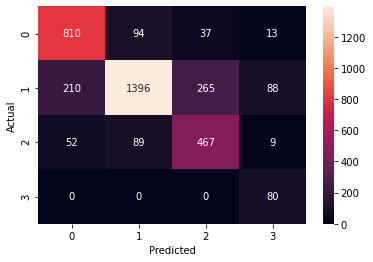

In [43]:
from sklearn.metrics import confusion_matrix
# neg 0, neu 1, pos 2, q 3
conf_mat = confusion_matrix(y_valid_b, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=lgr.classes_, yticklabels=lgr.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Model testing with user input data

In [63]:
# Load from file
from sklearn.externals import joblib
joblib_lgr = joblib.load('/content/joblib_lgr.pkl')
joblib_lgr

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [64]:
tfidf_1 = joblib.load("/content/tfidf.pickle")
scaler_2 = joblib.load('/content/scaler.pickle')

In [65]:
import pandas as pd
import numpy as np
# pipeline
texts = "แล้วมีสาขาไหนบ้างโปรนี้"
# create df
ui = pd.DataFrame({"texts": texts}, index=[0])
# preprocess
ui["processed"] = "|".join(process_text(texts))
ui["wc"] =  ui.processed.map(lambda x: len(x.split("|")))
ui["uwc"] = ui.processed.map(lambda x: len(set(x.split("|"))))
# transform
tfidf = tfidf_1.transform(ui["texts"])
scaler = scaler_2.transform(ui[["wc","uwc"]].astype(float))
tfidf_user = pd.DataFrame(tfidf.toarray())
scaler_user = pd.DataFrame(scaler)
user_texts = pd.concat([scaler_user, tfidf_user], axis=1)

In [66]:
user_texts

,0,1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,6117,6118,6119,6120,6121,6122,6123,6124,6125,6126,6127,6128,6129,6130,6131,6132,6133,6134,6135,6136,6137,6138,6139,6140,6141,6142,6143,6144,6145,6146,6147,6148,6149,6150,6151,6152,6153,6154,6155,6156
0,-0.44465,-0.498125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# neu 1, neg 0, q 3, pos 2
p = joblib_lgr.predict_proba(user_texts)
p

array([[0.02429741, 0.04469512, 0.01210147, 0.91890601]])